In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

from utils import *
from sklearn import preprocessing

import numpy as np

from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
# from sklearn.metrics import f1_score
from sklearn.metrics import f1_score, accuracy_score

In [9]:
data_patients_original = pd.read_csv('hypertension_patients.gz', compression='gzip')
data_charts_original = pd.read_csv('hypertension_charts.gz', compression='gzip')

In [10]:
def measurement(itemid, measure_name):
    print("----------------------------", measure_name, " ----------------------------")
    data_charts = data_charts_original[data_charts_original['itemid'] == itemid]
    
    value_counts = data_charts['hadm_id'].value_counts()
    to_remove = value_counts[value_counts < 2].index
    data_charts = data_charts[~data_charts.hadm_id.isin(to_remove)]
    
    data_charts = data_charts.sort_values("charttime")
    #     abs = data_charts.groupby('hadm_id')['valuenum'].agg([pd.np.min, pd.np.max, pd.np.mean])
    merged_data = pd.merge(data_charts, data_patients_original, on=['subject_id', 'hadm_id'], how='left')
    value_counts = merged_data.groupby('hadm_id')['valuenum'].count()
    to_remove = value_counts[value_counts > 300].index
    merged_data = merged_data[~merged_data.hadm_id.isin(to_remove)]

    merged_data = merged_data.sort_values("charttime")
    
    y_df = merged_data[['hadm_id', 'hypertension', 'train']]
    target_y_df = y_df.groupby('hadm_id')['hypertension'].unique().to_frame()

    train_mask = pd.merge(target_y_df, data_patients_original, on='hadm_id')['train']
    y_np = np.array([ls[0] for ls in target_y_df['hypertension'].values])

    y_train_np = y_np[train_mask == 1]
    y_test_np = y_np[train_mask == 0]
    
    features_df = merged_data.groupby('hadm_id')['valuenum'].apply(list)
    features_ls = features_df.tolist()
    X_np = np.array(pad_sequences(features_ls))
    X_np = np.expand_dims(X_np, axis=2)

    X_train_np = X_np[train_mask == 1]
    X_test_np = X_np[train_mask == 0]
    
    model = Sequential()
    model.add(LSTM(16, batch_input_shape=(None, X_np.shape[1], X_np.shape[2])))    #lstm layer
    model.add(Dropout(0.2))    #training process: 35% neurons mask to 0, but this won't happen in testing
    model.add(Dense(1, activation='sigmoid'))    # dense layer(normal neural nets layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     print(model.summary())
    
    model.fit(X_train_np, y_train_np,
          epochs=4, batch_size=64,
          verbose=1, shuffle=True,
          validation_data=(X_test_np, y_test_np))
    
    print("------------Performance------------")
    
    y_predict = model.predict(X_test_np)
    y_predict_prob = model.predict_proba(X_test_np)
    # modify!!
    y_pred_for_binary = np.array([0 if row < 0.5 else 1 for row in y_predict_prob])
#     y_pred_for_binary = np.argmax(y_predict, axis=1)
    
    

    fpr, tpr, thresholds = metrics.roc_curve(y_test_np, y_pred_for_binary, pos_label = 1)
    plot_roc(fpr, tpr, "5b_" + measure_name + "_roc_graph_neuron16.png")
    print("AUC score: ", metrics.roc_auc_score(y_test_np, y_pred_for_binary))
    print("F1 score: ", f1_score(y_test_np, y_pred_for_binary))
    print("Accuracy score: ", accuracy_score(y_test_np, y_pred_for_binary ))
#     print(f1_score(y_test_np, y_pred_for_f1, average="macro"))

---------------------------- heart_rate  ----------------------------
Train on 14313 samples, validate on 6076 samples
Epoch 1/4
14313/14313 [==============================] - 109s 8ms/sample - loss: 0.6960 - acc: 0.5333 - val_loss: 0.6852 - val_acc: 0.5604
Epoch 2/4
14313/14313 [==============================] - 107s 7ms/sample - loss: 0.6870 - acc: 0.5587 - val_loss: 0.6847 - val_acc: 0.5652
Epoch 3/4
14313/14313 [==============================] - 108s 8ms/sample - loss: 0.6862 - acc: 0.5605 - val_loss: 0.6847 - val_acc: 0.5652
Epoch 4/4
14313/14313 [==============================] - 109s 8ms/sample - loss: 0.6859 - acc: 0.5607 - val_loss: 0.6855 - val_acc: 0.5652
------------Performance------------
AUC score:  0.5
F1 score:  0.0
Accuracy score:  0.565174456879526


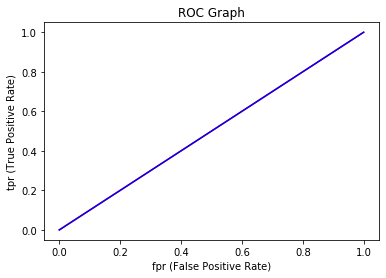

In [11]:
measurement(220045, "heart_rate")

---------------------------- Respiratory  ----------------------------
Train on 14317 samples, validate on 6079 samples
Epoch 1/4
14317/14317 [==============================] - 108s 8ms/sample - loss: 0.6998 - acc: 0.5361 - val_loss: 0.6810 - val_acc: 0.5656
Epoch 2/4
14317/14317 [==============================] - 108s 8ms/sample - loss: 0.6902 - acc: 0.5465 - val_loss: 0.6835 - val_acc: 0.5558
Epoch 3/4
14317/14317 [==============================] - 109s 8ms/sample - loss: 0.6869 - acc: 0.5510 - val_loss: 0.6817 - val_acc: 0.5647
Epoch 4/4
14317/14317 [==============================] - 108s 8ms/sample - loss: 0.6859 - acc: 0.5495 - val_loss: 0.6822 - val_acc: 0.5631
------------Performance------------
AUC score:  0.4982573874766265
F1 score:  0.007473841554559044
Accuracy score:  0.5630860338871525


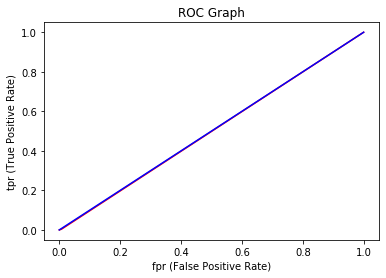

In [12]:
measurement(220210, "Respiratory")

---------------------------- O2  ----------------------------
Train on 14323 samples, validate on 6075 samples
Epoch 1/4
14323/14323 [==============================] - 110s 8ms/sample - loss: 0.6975 - acc: 0.5415 - val_loss: 0.6844 - val_acc: 0.5658
Epoch 2/4
14323/14323 [==============================] - 108s 8ms/sample - loss: 0.6949 - acc: 0.5356 - val_loss: 0.6844 - val_acc: 0.5658
Epoch 3/4
14323/14323 [==============================] - 107s 7ms/sample - loss: 0.6911 - acc: 0.5452 - val_loss: 0.6848 - val_acc: 0.5658
Epoch 4/4
14323/14323 [==============================] - 109s 8ms/sample - loss: 0.6904 - acc: 0.5460 - val_loss: 0.6844 - val_acc: 0.5658
------------Performance------------
AUC score:  0.5
F1 score:  0.0
Accuracy score:  0.565761316872428


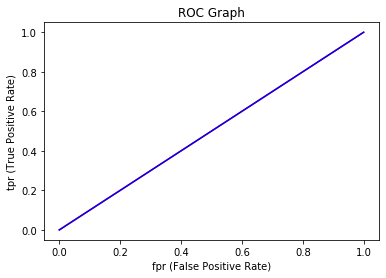

In [13]:
measurement(220277, "O2")

---------------------------- blood_pressure  ----------------------------
Train on 14797 samples, validate on 6297 samples
Epoch 1/4
14797/14797 [==============================] - 112s 8ms/sample - loss: 0.7167 - acc: 0.5180 - val_loss: 0.6890 - val_acc: 0.5698
Epoch 2/4
14797/14797 [==============================] - 112s 8ms/sample - loss: 0.6974 - acc: 0.5369 - val_loss: 0.6828 - val_acc: 0.5685
Epoch 3/4
14797/14797 [==============================] - 111s 8ms/sample - loss: 0.6917 - acc: 0.5451 - val_loss: 0.6832 - val_acc: 0.5685
Epoch 4/4
14797/14797 [==============================] - 110s 7ms/sample - loss: 0.6886 - acc: 0.5483 - val_loss: 0.6832 - val_acc: 0.5685
------------Performance------------
AUC score:  0.5
F1 score:  0.0
Accuracy score:  0.5685246942988724


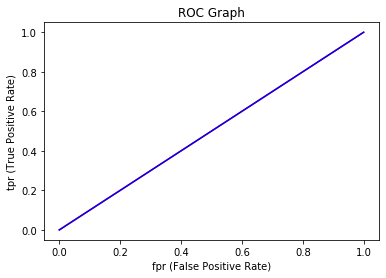

In [14]:
measurement(220181, "blood_pressure")